<a href="https://colab.research.google.com/github/Kavin-Balaji-NP-IT/CVNL_ASG/blob/main/CNN_AircraftClassification/CNN_AircraftClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import tarfile

url = 'https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz'
filename = 'fgvc-aircraft-2013b.tar.gz'
data_root = './fgvc-aircraft-2013b'

# Check if folder exists
if not os.path.exists(data_root):
    print(f"Dataset not found. Downloading from {url}...")

    # Download
    try:
        urllib.request.urlretrieve(url, filename)
        print("Download complete. Extracting...")

        # Extract
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
        print("Extraction complete. Dataset is ready!")
    except Exception as e:
        print(f"Error downloading or extracting: {e}")
else:
    print("Dataset already exists.")

Dataset not found. Downloading from https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz...
Download complete. Extracting...


/tmp/ipython-input-3745962605.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction complete. Dataset is ready!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Hyperparameters (Tuning)
DATA_ROOT = './fgvc-aircraft-2013b'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
class AircraftDataset(Dataset):
    def __init__(self, root_dir, split='train', level='family', transform=None):
        self.root_dir = Path(root_dir)
        self.images_dir = self.root_dir / 'data' / 'images'
        self.transform = transform
        self.level = level  # Store level (family/variant)

        # Load the specific text file based on the level
        # e.g., 'images_family_train.txt' OR 'images_variant_train.txt'
        annotation_file = self.root_dir / 'data' / f'images_{level}_{split}.txt'

        self.image_names = []
        self.labels = []

        if annotation_file.exists():
            with open(annotation_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(' ', 1)
                    if len(parts) == 2:
                        self.image_names.append(parts[0])
                        self.labels.append(parts[1])

        # Create class mapping
        self.classes = sorted(list(set(self.labels)))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = self.images_dir / f"{img_name}.jpg"

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        label_name = self.labels[idx]
        label_idx = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

In [4]:
CLASSIFICATION_LEVEL = 'family'

# Standard ImageNet normalization
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# Training transforms WITH Augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

# Validation transforms
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

# Setup DataLoaders with the selected CLASSIFICATION_LEVEL
if os.path.exists(DATA_ROOT):
    train_dataset = AircraftDataset(DATA_ROOT, split='train', level=CLASSIFICATION_LEVEL, transform=train_transform)
    val_dataset = AircraftDataset(DATA_ROOT, split='val', level=CLASSIFICATION_LEVEL, transform=val_transform)
    test_dataset = AircraftDataset(DATA_ROOT, split='test', level=CLASSIFICATION_LEVEL, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Level: {CLASSIFICATION_LEVEL}")
    print(f"Classes: {len(train_dataset.classes)}")
    print(f"Train images: {len(train_dataset)}")
else:
    print("Dataset not found!")

Level: family
Classes: 70
Train images: 3334


In [5]:
# Use ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
# This dynamically adjusts based on whether you loaded 'family' or 'variant' data
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

print(f"Model initialized for {num_classes} classes ({CLASSIFICATION_LEVEL}).")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Model initialized for 70 classes (family).


In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader.dataset), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader.dataset), 100. * correct / total

Starting training for 5 epochs on 'family' level...
Epoch 1/5 | Train Loss: 3.8909 Acc: 11.19% | Val Loss: 3.4429 Acc: 15.99%
Epoch 2/5 | Train Loss: 3.1015 Acc: 25.07% | Val Loss: 2.9893 Acc: 25.35%
Epoch 3/5 | Train Loss: 2.6435 Acc: 36.08% | Val Loss: 2.6749 Acc: 34.20%
Epoch 4/5 | Train Loss: 2.3413 Acc: 44.30% | Val Loss: 2.5038 Acc: 36.48%
Epoch 5/5 | Train Loss: 2.1269 Acc: 47.84% | Val Loss: 2.3636 Acc: 40.29%
Total time: 400s

SUCCESS: Model saved to 'family_model.pth'


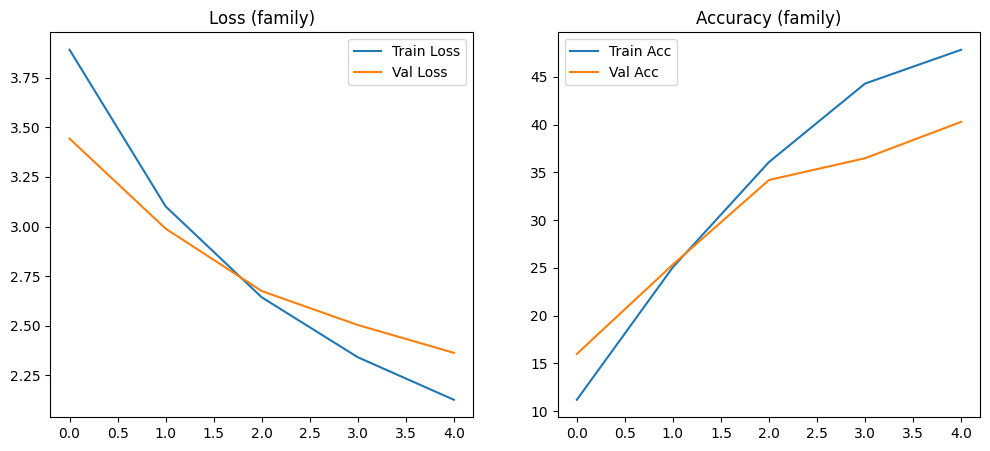

In [7]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Starting training for {NUM_EPOCHS} epochs on '{CLASSIFICATION_LEVEL}' level...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    v_loss, v_acc = evaluate(model, val_loader, criterion, DEVICE)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accs.append(t_acc)
    val_accs.append(v_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}%")

print(f"Total time: {(time.time() - start_time):.0f}s")

# --- SAVE AUTOMATICALLY BASED ON LEVEL ---
save_filename = f"{CLASSIFICATION_LEVEL}_model.pth"
torch.save(model.state_dict(), save_filename)
print(f"\nSUCCESS: Model saved to '{save_filename}'")

# Plotting Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title(f"Loss ({CLASSIFICATION_LEVEL})")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title(f"Accuracy ({CLASSIFICATION_LEVEL})")
plt.legend()
plt.show()

Running final evaluation on Test Set...

--- Final Metrics ---
Accuracy:  41.46%
Precision: 42.72%
Recall:    41.46%
F1-Score:  38.32%


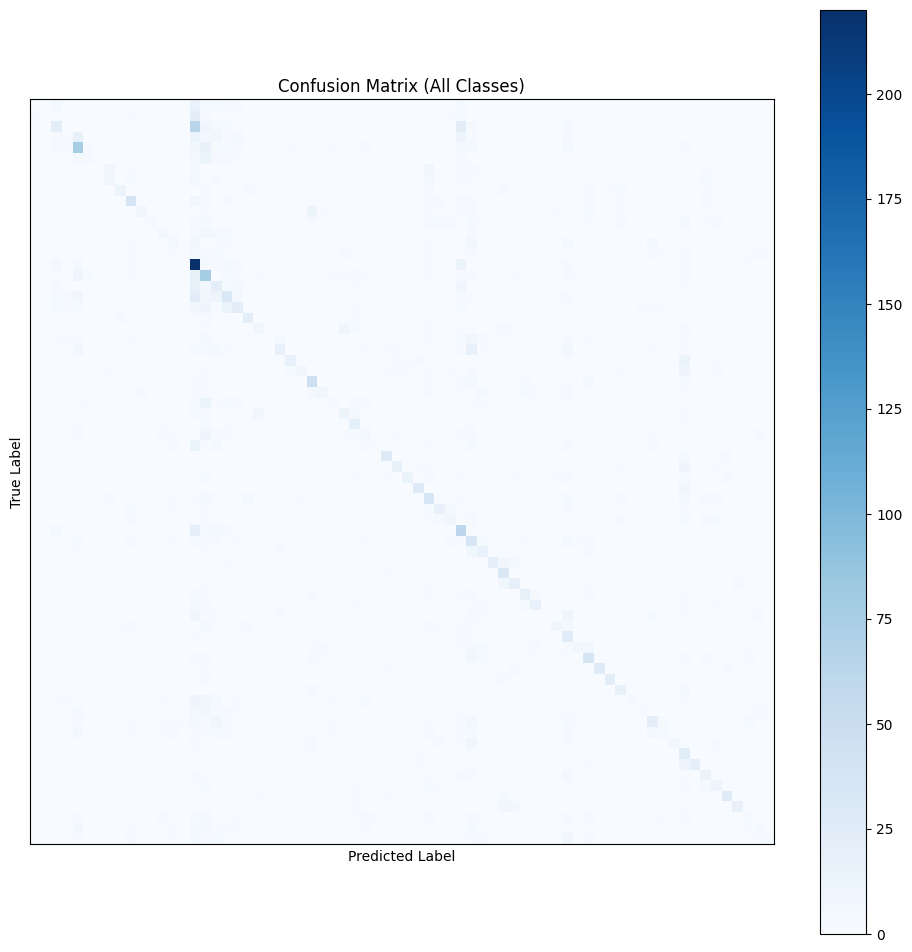


--- Common Errors ---
Example 1: True 'Boeing 707' -> Predicted 'Boeing 737'
Example 2: True 'Boeing 707' -> Predicted 'Boeing 757'
Example 3: True 'Boeing 707' -> Predicted 'Boeing 757'
Example 4: True 'Boeing 707' -> Predicted 'L-1011'
Example 5: True 'Boeing 707' -> Predicted 'Boeing 747'


In [8]:
# Gather all predictions from Test Set
all_preds = []
all_labels = []

model.eval()
print("Running final evaluation on Test Set...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_preds)
# Weighted average accounts for class imbalance
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\n--- Final Metrics ---")
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (All Classes)")
plt.colorbar()
# Hiding ticks for readability since there are 70+ classes
plt.xticks([])
plt.yticks([])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Show Common Misclassifications
print("\n--- Common Errors ---")
misclassified_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

for i in range(min(5, len(misclassified_indices))):
    idx = misclassified_indices[i]
    true_name = train_dataset.classes[all_labels[idx]]
    pred_name = train_dataset.classes[all_preds[idx]]
    print(f"Example {i+1}: True '{true_name}' -> Predicted '{pred_name}'")

In [9]:
import requests
from io import BytesIO
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Define the Preprocessing (Must match what we used for Validation)
#    Resize -> CenterCrop -> ToTensor -> Normalize
predict_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_image(image_source, source_type='upload'):
    """
    image_source: Filename (if upload) or URL (if url)
    source_type: 'upload' or 'url'
    """
    # Load the Image
    try:
        if source_type == 'url':
            response = requests.get(image_source)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_source).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Prepare the image for the model
    input_tensor = predict_transform(img)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)
    input_batch = input_batch.to(DEVICE)

    # Run Prediction
    model.eval()
    with torch.no_grad():
        output = model(input_batch)
        # Get probabilities
        probs = torch.nn.functional.softmax(output[0], dim=0)

    # Get Top 3 Predictions
    top_probs, top_indices = torch.topk(probs, 3)

    # Display Result
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    # Get the name of the top prediction
    top_cat_id = top_indices[0].item()
    top_cat_name = train_dataset.classes[top_cat_id]
    top_score = top_probs[0].item()

    plt.title(f"Prediction: {top_cat_name}\nConfidence: {top_score*100:.2f}%",
              color='green', fontweight='bold', fontsize=14)
    plt.show()

    print(f"\n--- Top 3 Matches ---")
    for i in range(3):
        idx = top_indices[i].item()
        name = train_dataset.classes[idx]
        score = top_probs[i].item()
        print(f"{i+1}. {name} ({score*100:.2f}%)")

try:
  from google.colab import files
  print("Please upload an aircraft image from your computer...")
  uploaded = files.upload()

  for filename in uploaded.keys():
      print(f"\nProcessing {filename}...")
      predict_image(filename, source_type='upload')

except ImportError:
  # If running locally (not Colab), use a sample URL test
  print("Not running in Colab. Testing with a sample URL...")
  sample_url = "https://upload.wikimedia.org/wikipedia/commons/5/5e/ANA_777-300_JA754A.jpg"
  predict_image(sample_url, source_type='url')

Please upload an aircraft image from your computer...
